In [55]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from torch import embedding
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
import nltk
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfFile, PdfPages
from statistics import mean
from turtle import filling
from astropy.timeseries import LombScargle
from gatspy.periodic import LombScargleFast
from gatspy.periodic import LombScargle
from ctypes.wintypes import SIZE
import matplotlib.transforms as transforms
from matplotlib.offsetbox import AnchoredText
from scipy.signal import argrelextrema


In [56]:
#subject6 的最明顯波長是68.4813s
#space = 17.12 #sample step size
#timeframe = 17.12

global q
q=0

In [57]:
def calculate(gcs,destination,timeframe,space,num_of_extremum): #所以gcs要是string
    global results_name
    global num_ex 
    num_ex = num_of_extremum
    global df
    df = pd.read_csv(gcs) 

    df['Start_time'] = pd.to_numeric(df['Start_time'])
    #df['end_time'] = pd.to_numeric(df['end_time'])
    global all_sentences001
    all_sentences001 = []
    t=0
    while t<480:
        sentences = []
        for index, rows in df.loc[(df["Start_time"]>=t) & (df["Start_time"]<=(t+timeframe))].iterrows():
            sentences.append(rows["Words"])
        all_sentences001.append(" ".join(sentences))
        t+=space

    
    model = SentenceTransformer('all-MiniLM-L6-v2')
    global SBERT 
    SBERT= []

    def get_cosine_similarity(feature_vec_1, feature_vec_2):    
        return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]
    # Two lists of sentences
    for i in range(0,len(all_sentences001)-1):
        #Compute embedding for both lists
        embeddings1 = model.encode(all_sentences001[i], convert_to_tensor=True)
        embeddings2 = model.encode(all_sentences001[i+1], convert_to_tensor=True)

        #Compute cosine-similarities
        cosine_scores = util.cos_sim(embeddings1, embeddings2)
        # convert from PyTorch tensor to numpy array
        SBERT.append(get_cosine_similarity(embeddings1, embeddings2))
    ######
    
    all_sentences001 = []
    stops = set(stopwords.words('english'))
    t=0
    while t <480:
        sentences = []
        for index, rows in df.loc[(df["Start_time"]>=t) & (df["Start_time"]<=(t+timeframe))].iterrows():
            if rows["Words"].lower() not in stops:
                sentences.append(rows["Words"].lower())
                #print(rows["Words"])
        all_sentences001.append(" ".join(sentences))
        #print(t)
        t += space 
    ''' 舊的sample step
    for t in range(0,480,0.5):
        sentences = []
        for index, rows in df.loc[(df["Start_time"]>=t) & (df["Start_time"]<=(t+10))].iterrows():
            if rows["Words"].lower() not in stops:
                sentences.append(rows["Words"].lower())
        all_sentences001.append(" ".join(sentences))
    '''    
    #nltk.download('omw-1.4')
    #nltk.download('wordnet')
    #nltk.download('stopwords')
    global pair_counts
    pair_counts = []
    stops = set(stopwords.words('english'))
    global all_sentences_wu_sum
    all_sentences_wu_sum = []
    global all_sentences_wu_sum_divided
    all_sentences_wu_sum_divided = []
    for sentence_num in range(0,len(all_sentences001)): #現在第幾句
        wu_pulmer_sum = 0
        the_sentence = str(all_sentences001[sentence_num]).split()
        #print(the_sentence)
        timeframe_pairs_count = 0
        for words_num in range(0, (len(the_sentence)-1)): #標定第一個字
            if len(wordnet.synsets(the_sentence[words_num])) > 0 :
                syns1 = wordnet.synsets(the_sentence[words_num])
                syns1_num = len(syns1)
            else:
                continue
            for words_num2 in range((words_num+1), len(the_sentence)): #標定第二個字
                if len(wordnet.synsets(the_sentence[words_num2])) > 0 :
                    syns2 = wordnet.synsets(the_sentence[words_num2])
                    syns2_num = len(syns2)
                    for i in range(0, syns1_num):
                        for u in range(0, syns2_num):
                            #print(the_sentence[words_num],"的",syns1[i]," ", the_sentence[words_num2],"的",syns2[u]," " ,syns1[i].wup_similarity(syns2[u]))
                            wu_pulmer_sum += syns1[i].wup_similarity(syns2[u])
                            timeframe_pairs_count += 1
                else:
                    continue
        if timeframe_pairs_count != 0:
            all_sentences_wu_sum_divided.append(wu_pulmer_sum/timeframe_pairs_count) #算出除以pairs數量的平均值
        else: 
            all_sentences_wu_sum_divided.append(wu_pulmer_sum)
        all_sentences_wu_sum.append(wu_pulmer_sum)
        pair_counts.append(timeframe_pairs_count)
        #print(all_sentences_wu_sum)
        global wu_difference
        wu_difference = []
        for x in range(len(all_sentences_wu_sum)-1):
            wu_difference.append(all_sentences_wu_sum[x+1]-all_sentences_wu_sum[x])

    from sklearn import preprocessing

    results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = ['SBERT',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])
    if q<10:
        results_csv.to_csv(f"data/Text/00{q}({destination}).csv")
        results_name = f"data/Text/00{q}({destination}).csv"
        print(results_name)
    else:
        results_csv.to_csv(f"data/Text/0{q}({destination}).csv")
        results_name = f"data/Text/0{q}({destination}).csv"
        print(results_name)
    """ # for normalization
    wu_difference = np.array(wu_difference)
    SBERT = np.array(SBERT)
    #normalized_SBERT = preprocessing.normalize([SBERT])
    #normalized_wu_difference = preprocessing.normalize([wu_difference])


    min_max_scaler = preprocessing.MinMaxScaler()
    SBERT = np.reshape(SBERT,(479,1))
    wu_difference = np.reshape(wu_difference,(479,1))
    global normalized_SBERT
    global normalized_wu_difference
    normalized_SBERT  = min_max_scaler.fit_transform(SBERT)
    normalized_wu_difference  = min_max_scaler.fit_transform(wu_difference)
    """



    
    
    
    n_PSD=[] #用來畫pdf的t
    b=0
    while b<len(df):
        n_PSD += [b+1]
        b+=1
    if q<10:
            df = pd.read_csv(f"data/Text/00{q}({destination}).csv")
    else:
        df = pd.read_csv(f"data/Text/0{q}({destination}).csv")
    
    
    global pdfFile
    if q <10:
        pdfFile = PdfPages(f"data/all_in_one/00{q}({destination}.pdf")
    else: 
        pdfFile = PdfPages(f"data/all_in_one/0{q}({destination}.pdf")
    
    wu_pulmer_score = list(df["Wu-Pulmer"])
    
    SBERT = list(df["SBERT"])
    
    Wu_Pulmer_Divided = list(df["Wu-Pulmer_divided"])
    
    pair_counts = list(df["pair_counts"])
    df  = df.drop(columns= ["Unnamed: 0"])

    fig = plt.figure(figsize=(20,6))
    #plt.rcParams["figure.figsize"] = (20, 6)
    plt.plot(wu_pulmer_score,label = "wu_pulmer")
    plt.plot(pair_counts, label = "pair counts")
    plt.xlabel("Timeframe(no.)")
    plt.ylabel("wu-pulmer score")
    plt.title(f"subject:{q}     raw_wu_pulmer_score ")
    plt.xlim(0,500)
    plt.grid()
    plt.legend()
    plt.show
    pdfFile.savefig(fig)

    fig = plt.figure(figsize=(20,6))
    plt.plot(SBERT,label = "SBERT")
    plt.xlabel("Timeframe(no.)")
    plt.ylabel("SBERT score")
    plt.title(f"subject:{q}     SBERT")
    plt.xlim(0,20)
    plt.grid()
    plt.legend()
    plt.show
    pdfFile.savefig(fig)

    fig = plt.figure(figsize=(20,6))
    plt.plot(Wu_Pulmer_Divided,label = "Wu_Pulmer_Divided")
    plt.xlabel("Timeframe(no.)")
    plt.ylabel("wu_pulmere_divided")
    plt.title(f"subject:{q}     wu_pulmer_divided_by_pairs")
    plt.grid()
    plt.xlim(0,500)
    plt.ylim(0,0.5)
    plt.show
    pdfFile.savefig(fig)

    #https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
    name = ["count", "mean", "std", "min", "25%", "50%" ,"75%", "max"]
    new_df = df.describe()
    #df["parameters"] = name
    new_df.insert (0, " ", name)
    fig, ax =plt.subplots(figsize=(20,5))
    ax.axis('auto')
    ax.axis('off')
    the_table = ax.table(cellText=new_df.values,colLabels=new_df.columns,loc='center',fontsize = 10.0)
    plt.rcParams.update({'font.size': 22})
    #https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot

    pdfFile.savefig(fig, bbox_inches='tight')











    

In [58]:
num=list()
def read(path):
    df = pd.read_csv(path)
    
    global wu_pulmer_score
    wu_pulmer_score = list(df["Wu-Pulmer"])
    global SBERT
    SBERT = list(df["SBERT"])
    global Wu_Pulmer_Divided 
    Wu_Pulmer_Divided = list(df["Wu-Pulmer_divided"])
    global pair_counts
    pair_counts = list(df["pair_counts"])
    q=0
    global num
    num=[]
    while q <len(df):
        num += [q]
        q+=1

In [59]:
from ctypes.wintypes import SIZE


def calculate_PSD(a):
    num_of_extremum = num_ex
    frequency, power = LombScargle(num,wu_pulmer_score).autopower(minimum_frequency=0.01,maximum_frequency=0.1)
    fig = plt.figure(figsize = (20,6))
    #fig, ax=plt.subplots(figsize = (20,6))
    plt.title(f"subject:{a}     raw_wu_pulmer_score_PSD ")
    plt.grid()
    plt.xlabel("frequency")
    plt.plot(frequency, power)   
    power_new = np.sort(power)
    extremum = np.sort(power[argrelextrema(power,np.greater)])
    pmaxf = np.array([])
    for i in range(1, (num_of_extremum+1)):
        pmaxf = np.append(pmaxf,frequency[np.where(power == extremum[-i])])
        #plt.axhline(y=extremum[-i], linestyle = "dashed", xmin=0.01, xmax=20,color = "red") #這條是y水平線，想要可以加
        plt.axvline(x = pmaxf[-1], linestyle = "dashed", ymin=0, ymax = 25 ,color = "red") #因為pmaxf一直在新增，所以輪到那圈時的pmax[-1]就會是那圈新增的第i大的power的f
    #trans = transforms.blended_transform_factory( ax.get_yticklabels()[0].get_transform(), ax.transData)
    #plt.text(0,23, "{:.0f}".format(max(power)), color="red", transform=trans, ha="right", va="center")
    #plt.scatter(argrelextrema(power,np.greater), power[argrelextrema(power,np.greater)],c='red') #找極值用的
    plt.annotate(f'f={pmaxf[:]}\npmax={extremum[:-num_of_extremum-1:-1]}', xy=(0.4, 0.7), xycoords='axes fraction') 
    pdfFile.savefig(fig)
    according_power1 = np.array([])
    for z in range(0,num_of_extremum):
        according_power1 = np.append(according_power1,power[np.where(frequency == pmaxf[z])])
    pmaxf1 = list(pmaxf)
    according_power1 = list(according_power1)
    

    


    frequency, power = LombScargle(num,SBERT).autopower(minimum_frequency=0.01,maximum_frequency=0.1)
    fig = plt.figure(figsize = (20,6))
    plt.title(f"subject:{a}     SBERT_PSD ")
    plt.grid()
    plt.show
    plt.xlabel("frequency")
    plt.plot(frequency, power)    
    power_new = np.sort(power)
    extremum = np.sort(power[argrelextrema(power,np.greater)])
    pmaxf = np.array([])
    for i in range(1, (num_of_extremum+1)):
        pmaxf = np.append(pmaxf,frequency[np.where(power == extremum[-i])])
        #plt.axhline(y=extremum[-i], linestyle = "dashed", xmin=0.01, xmax=20,color = "red") #這條是y水平線，想要可以加
        plt.axvline(x = pmaxf[-1], linestyle = "dashed", ymin=0, ymax = 25 ,color = "red") #因為pmaxf一直在新增，所以輪到那圈時的pmax[-1]就會是那圈新增的第i大的power的f
    plt.annotate(f'f={pmaxf[:]}\npmax={extremum[:-num_of_extremum-1:-1]}', xy=(0.4, 0.7), xycoords='axes fraction') 
    pdfFile.savefig(fig)
    according_power2 = np.array([])
    for z in range(0,num_of_extremum):
        according_power2 = np.append(according_power2,power[np.where(frequency == pmaxf[z])])
    pmaxf2 = list(pmaxf)
    according_power2 = list(according_power2)


    frequency, power = LombScargle(num,Wu_Pulmer_Divided).autopower(minimum_frequency=0.01,maximum_frequency=0.1)
    fig = plt.figure(figsize = (20,6))
    plt.title(f"subject:{a}     wu_palmer_divided_PSD ")
    plt.grid()
    plt.show
    plt.xlabel("frequency")
    plt.plot(frequency, power)    
    power_new = np.sort(power)
    extremum = np.sort(power[argrelextrema(power,np.greater)])
    pmaxf = np.array([])
    for i in range(1, (num_of_extremum+1)):
        pmaxf = np.append(pmaxf,frequency[np.where(power == extremum[-i])])
        #plt.axhline(y=extremum[-i], linestyle = "dashed", xmin=0.01, xmax=20,color = "red") #這條是y水平線，想要可以加
        plt.axvline(x = pmaxf[-1], linestyle = "dashed", ymin=0, ymax = 25 ,color = "red") #因為pmaxf一直在新增，所以輪到那圈時的pmax[-1]就會是那圈新增的第i大的power的f
    plt.annotate(f'f={pmaxf[:]}\npmax={extremum[:-num_of_extremum-1:-1]}', xy=(0.4, 0.7), xycoords='axes fraction') 
    pdfFile.savefig(fig)
    according_power3 = np.array([])
    for z in range(0,num_of_extremum):
        according_power3 = np.append(according_power3,power[np.where(frequency == pmaxf[z])])
    pmaxf3 = list(pmaxf)
    according_power3 = list(according_power3)


    results_csv = pd.DataFrame(zip(pmaxf1,according_power1,pmaxf2,according_power2,pmaxf3,according_power3), columns = ["frequency(wu)","power(wu)","frequency(SBERT)","power(SBERT)","frequency(wu2)","power(wu2)"])
    

參數表:<br>
all_sentences001: 所有的句子整合(沒有刪掉stop words)<br>
SBERT: 具有全部SBERT similarity的list<br>
all_sentences_wu_sum: 每句話的wu-pulmer similarity算出來的平均的list<br>
wu_difference: 兩句兩句減掉wu similarity的list<br>
normalized_SBERT: 就是表準化過後的SBERT list<br>
normalized_wu_difference: 標準化過後的wu_pulmer difference<br>
這邊注意wu-pulmer的different based應該不能這樣算

data/Text/006(f_max1).csv


ValueError: optimizer must be a PeriodicOptimizer instance: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27] has no best_period method

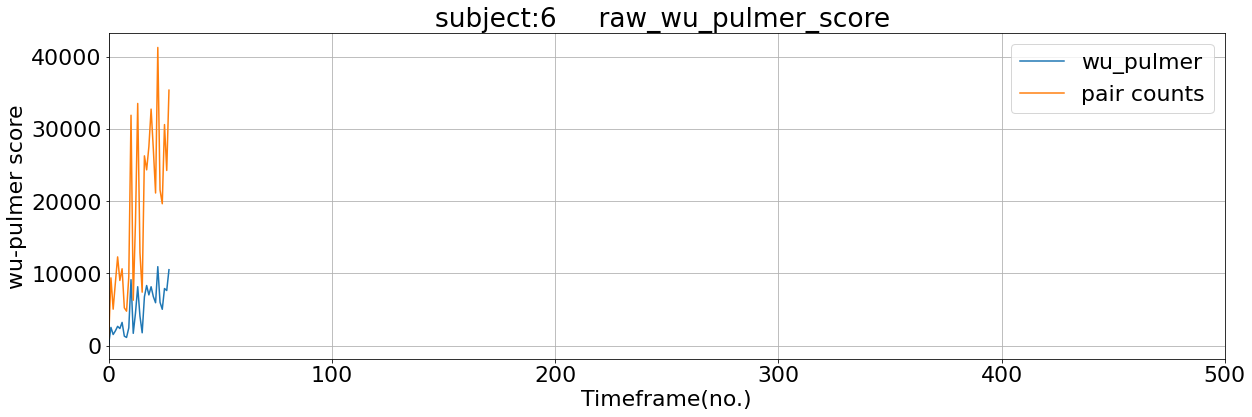

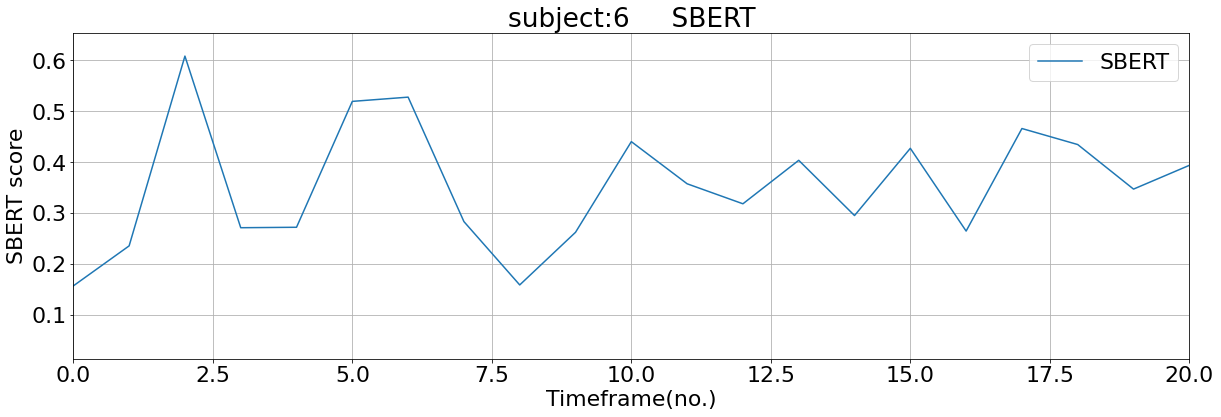

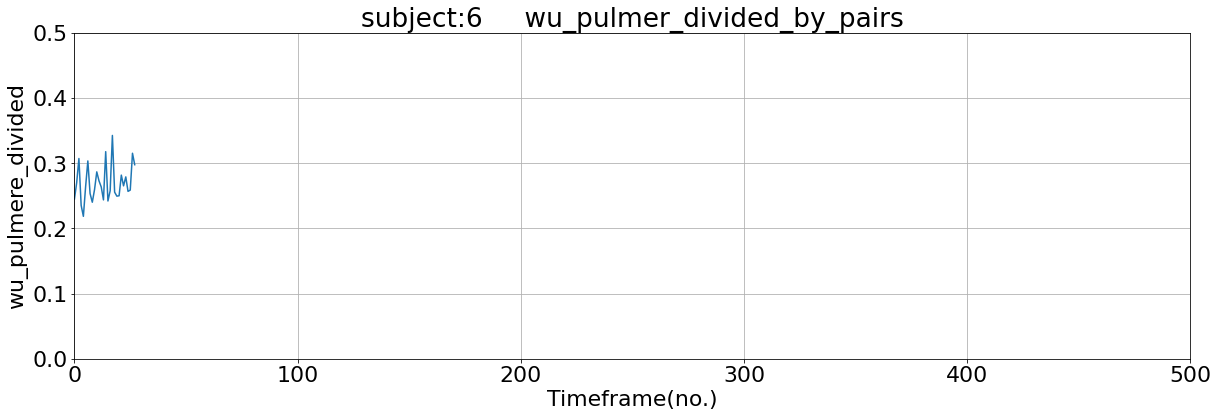

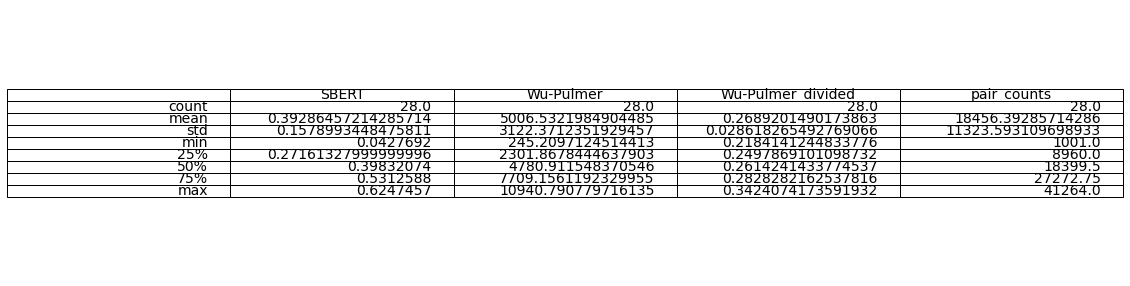

In [60]:
x=6
q=x
calculate(f"data/Text/00{x}(done).csv","f_max1",17.12,17.12,1)
read(results_name)
calculate_PSD(x)
pdfFile.close()

In [ ]:

for x in range(1,1):
    if x<10:
        q=x
        calculate(f"data/Text/00{x}(done).csv","f_max1",17.12,17.12,1)
        
    else:
        try:
            calculate(f"data/Text/0{x}(done).csv","f_max1",17.12,17.12,1)
        except:
            continue


In [ ]:
print(len(all_sentences001))
print(len(SBERT))

29
28


In [ ]:
'''
for i in range(18,24):
    if i<10:
        try:
            calculate(f"data/Text/00{i}(done).csv")
            results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = ['SBERT',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])
            results_csv.to_csv(f'data/Text/00{i}(results).csv')
        except:
            print("error:", i)
            continue
    else:
        try:
            calculate(f"data/Text/0{i}(done).csv")
            results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = ['SBERT',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])
            results_csv.to_csv(f'data/Text/0{i}(results).csv')
        except:
            print("error:", i)
            continue
'''

'\nfor i in range(18,24):\n    if i<10:\n        try:\n            calculate(f"data/Text/00{i}(done).csv")\n            results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = [\'SBERT\',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])\n            results_csv.to_csv(f\'data/Text/00{i}(results).csv\')\n        except:\n            print("error:", i)\n            continue\n    else:\n        try:\n            calculate(f"data/Text/0{i}(done).csv")\n            results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = [\'SBERT\',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])\n            results_csv.to_csv(f\'data/Text/0{i}(results).csv\')\n        except:\n            print("error:", i)\n            continue\n'

In [ ]:
results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = ['SBERT',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])
print(results_csv.tail(5))

       SBERT     Wu-Pulmer  Wu-Pulmer_divided  pair_counts
23  0.615163   6010.452482           0.278856        21554
24  0.624746   5042.614357           0.256687        19645
25  0.561388   7913.619275           0.258615        30600
26  0.576400   7641.001734           0.315106        24249
27  0.042769  10520.670262           0.297556        35357
